In [1]:
import numpy as np
import torch
import math
import importlib
# import socialSigLayers
# importlib.reload(socialSigLayers)
import pandas as pd
import random
import matplotlib.pyplot as plt
import sklearn
from copy import deepcopy

In [2]:
def scale(x, out_range=(0, 29)):
    domain = np.min(x), np.max(x)
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    to_ret = y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2
    return to_ret.astype(int)


def construct_indices(weights, dim, length):
    indices = []
    weights = scale(weights.clone().detach().numpy())
    for i in range(0, dim):
        to_add = i * length
        cur_indices = [i + to_add for i in weights]
        indices.append(cur_indices)
    return torch.tensor(indices, dtype = torch.int64)

In [3]:
# class bilinearImputation(torch.nn.Module):
#     '''
#     Class to create the social signature image
#     '''
#     def __init__(self, X):
#         super(bilinearImputation, self).__init__()
#         self.W = torch.nn.Parameter(torch.tensor(np.arange(0,X.shape[1]), dtype = torch.float32, requires_grad=True))
#         self.outDim = [10,10]
#         self.inDim = math.ceil(math.sqrt(X.shape[1]))

#     def forward(self, batchX):
#         self.X = batchX
#         taken = torch.take(self.X, construct_indices(self.W, self.X.shape[0], self.W.shape[0]))
#         self.X.data = self.X.data.copy_(taken.data)        
#         inDataSize = self.W.shape[0] #Data we have per dimension
#         targetSize = self.inDim ** 2
#         paddingOffset = targetSize - inDataSize
#         paddedInX = torch.nn.functional.pad(input=self.X, pad=(0,paddingOffset), mode="constant", value=0)
#         buildImage = torch.reshape(paddedInX,(self.X.shape[0], 1, self.inDim, self.inDim))   
#         return torch.nn.functional.interpolate(buildImage, size=([self.outDim[0], self.outDim[1]]), mode='bilinear')




class bilinearImputation(torch.nn.Module):
    '''
    Class to create the social signature image
    '''
    def __init__(self, X):
        super(bilinearImputation, self).__init__()
        self.W = torch.nn.Parameter(torch.tensor(np.arange(0, X.shape[1]), dtype = torch.float32, requires_grad=True))
        self.outDim = [10,10]
        self.inDim = math.ceil(math.sqrt(X.shape[1]))

    def forward(self, batchX):
        
        # print("    W at beginning: ", torch.tensor(self.W, dtype = torch.int)) 

        # taken = torch.take(batchX, construct_indices(self.W, batchX.shape[0], self.W.shape[0]))
        taken = torch.take(batchX, construct_indices(torch.clamp(torch.tensor(self.W, dtype = torch.int64), 0, 29), batchX.shape[0], self.W.shape[0]))

        batchX.data = batchX.data.copy_(taken.data)
        # print("batchX.data: ", batchX.data.copy_(taken.data))  
        
        inDataSize = self.W.shape[0] #Data we have per dimension
        targetSize = self.inDim ** 2
        paddingOffset = targetSize - inDataSize
        paddedInX = torch.nn.functional.pad(input=batchX, pad=(0,paddingOffset), mode="constant", value=0)
        buildImage = torch.reshape(paddedInX,(batchX.shape[0], 1, self.inDim, self.inDim))   
        return torch.nn.functional.interpolate(buildImage, size=([self.outDim[0], self.outDim[1]]), mode='bilinear')


In [4]:
###### Define our model
class SocialSigNet(torch.nn.Module):
    def __init__(self, X):
        super().__init__()
        self.SocialSig = bilinearImputation(X=X)                
        self.conv2d = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxPool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)#,
            # torch.nn.Sequential(
            #     torch.nn.Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False),
            #     torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            # )
        )
        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.seqBlock1 = torch.nn.Sequential(self.block1, self.block1)
        self.seqBlock2 = torch.nn.Sequential(self.block2, self.block3)
    

        self.block4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            #   (downsample): Sequential(
            #     (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
            #     (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            #   )
        )
        self.block5 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.seqBlock3 = torch.nn.Sequential(self.block4, self.block5)

        self.block6 = torch.nn.Sequential(
                torch.nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            #   (downsample): Sequential(
            #     (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
            #     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            #   )
            )
        self.block7 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.seqBlock4 = torch.nn.Sequential(self.block6, self.block7)

        self.linear = torch.nn.Linear(512000, 1000)

        
    def forward(self, X, epoch):
        out = self.SocialSig(X) # OUT:  torch.Size([100, 1, 10, 10])

        pd.DataFrame(out.clone()[0].flatten()).to_csv("./figs2/im" + str(epoch) + ".csv")

        out = self.conv2d(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxPool(out)
        out = self.seqBlock1(out)
        out = self.seqBlock2(out)
        out = self.seqBlock3(out)
        out = self.seqBlock4(out)
        out = self.relu(out)
        out = out.flatten()
        out = self.linear(out)
        # print("OUT: ", out.shape)
        # print("OUT: ", out)
        return out

In [5]:
####### Load our Data
from sklearn import preprocessing
devSet = pd.read_csv("./us_migration.csv")
devSet = devSet.loc[:, ~devSet.columns.str.contains('^Unnamed')]
devSet = devSet.apply(lambda x: pd.to_numeric(x, errors='coerce'))
devSet = devSet.dropna(axis=1)

y = torch.Tensor(devSet['US_MIG_05_10'].values)
X = devSet.loc[:, devSet.columns != "US_MIG_05_10"].values

mMScale = preprocessing.MinMaxScaler()
X = mMScale.fit_transform(X)


In [6]:
#y - 'number_moved'
#x - 'everything else that is or can be represented as a float.'

####### Build and fit the Model
model = SocialSigNet(X=X)
lr = 1e-7
batchSize = 1000

In [7]:
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [8]:
def update_function(param, grad, loss, learning_rate):
    # print(grad.mean(axis = 0))
    # print("    WEIGHT UPDATES: ", param - learning_rate * grad.mean(axis = 0)[0])
    return param - learning_rate * grad.mean(axis = 0)


def mae(real, pred):
    return torch.abs(real - pred).mean()

In [9]:
for t in range(2):
    #Batches
    # batchObs = random.sample(range(0, len(y)), batchSize)
    batchObs = [i for i in range(0, 1000)]
    modelX = X[batchObs]
    # print(modelX.shape)
    modelX = torch.tensor(list(modelX), requires_grad = True, dtype = torch.float32)
    modely = torch.tensor(y[batchObs], dtype = torch.float32)  # MADE A CHANGE HERE 
    
    


    print("EPOCH: ", t)
    y_pred = model(modelX, t)
    # print(y_pred)
    loss = criterion(y_pred, modely)  
    # print()  
    print("    Loss:     ", loss.item(), "     MAE: ", mae(y_pred, modely).item())
    
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    grad = torch.autograd.grad(outputs=loss, inputs=modelX, retain_graph = True)
    # print("    GRADIENT: ", grad[0][0].shape)
    # print("    GRADIENT: ", grad[0])
    loss.backward()
    optimizer.step()
    # https://discuss.pytorch.org/t/updatation-of-parameters-without-using-optimizer-step/34244/4
    with torch.no_grad():
        for name, p in model.named_parameters():
            if name == 'SocialSig.W':
            # print("    In with:        ", p.data)
                new_val = update_function(p, grad[0], loss, lr)
            # print("NEW WEIGHTS: ", new_val)
                p.copy_(new_val)
    
    print("\n")

ipykernel_launcher:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
ipykernel_launcher:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/heatherbaier/anaconda/envs/caoe/lib/python3.6/site-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
EPOCH:  0
    Loss:      349330816.0      MAE:  381.7048645019531


EPOCH:  1
    Loss:      335632288.0      MAE:  374.1263122558594




In [10]:
y_pred[0:10]

tensor([19.3445,  3.6170, 17.9898,  3.4419, 21.5767,  6.7872,  4.2214,  6.7350,
         0.6540, 41.4034], grad_fn=<SliceBackward>)

In [11]:
modely[0:10]

tensor([ 961.,  154.,  905.,  225., 1071.,  337.,  204.,  320.,   61., 2063.])

In [12]:
print("Model.parameters")
print(model.parameters)
print("SSParam")
print(list(model.SocialSig.parameters()))
print("is_leaf")
print(list(model.SocialSig.parameters())[0].is_leaf)
print("gradfn")
print(list(model.SocialSig.parameters())[0].grad_fn)
print("Grad")
print(list(model.SocialSig.parameters())[0].grad)

Model.parameters
<bound method Module.parameters of SocialSigNet(
  (SocialSig): bilinearImputation()
  (conv2d): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxPool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (block1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [811]:
def show_image(best_epoch):
    df = pd.read_csv("./figs/im" + str(best_epoch) + ".csv")
    df["0"] = df["0"].str.split("(").str[1].str.split(",").str[0].astype(float)
    plt.imshow(np.reshape(np.array(df["0"]), (10, 10)))

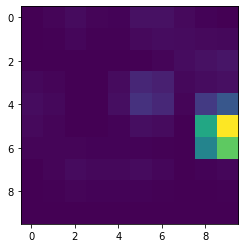

In [812]:
show_image(10)

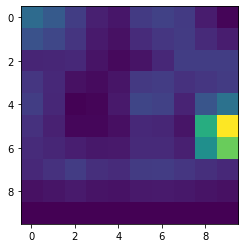

In [813]:
show_image(0)

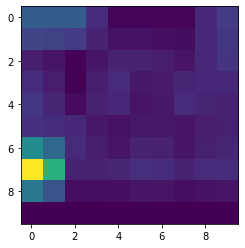

In [814]:
show_image(1)